In [155]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [156]:
root_dir = '/kaggle/input/crocodilo/new_fer2013_cropped/train'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

In [157]:
classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [158]:
dataset_path = '/kaggle/input/crocodilo/new_fer2013_cropped'

In [159]:
mean = 0.456
std = 0.224
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((48, 48)),             
    transforms.RandomRotation(degrees=15),       
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.RandomVerticalFlip(p=0.5),   
    transforms.ToTensor(),
    transforms.RandomErasing(
        p=0.5,                  
        scale=(0.01, 0.2),     
        ratio=(0.2, 2.2),  
        value=0                
    ),
    transforms.Normalize([0.456], [0.224])
])

In [160]:
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [161]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [162]:
train_labels = train_dataset.targets  
class_indices = list(range(len(classes)))
class_weights = compute_class_weight(
    'balanced', 
    classes=class_indices, 
    y=train_labels
)

In [163]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

Feature batch shape: torch.Size([32, 1, 48, 48])
Labels batch shape: torch.Size([32])


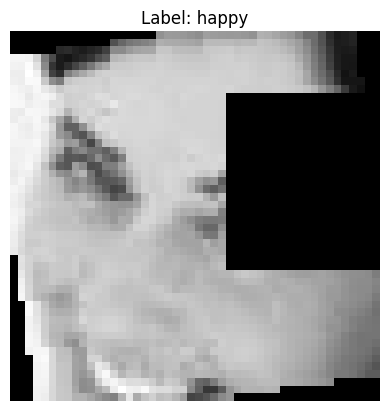

In [164]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[5].permute(1, 2, 0)  # C, H, W -> H, W, C
img = img * std + mean  # unnormalize back to [0,1] range
img = img.clamp(0, 1)
label = train_labels[5].item()
plt.imshow(img.numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [165]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [166]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)
        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [167]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [168]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [169]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) 
            train_correct += (torch.argmax(outputs, 1) == labels).sum().item()
            total_samples += labels.size(0)

        train_loss /= total_samples
        train_acc = train_correct / total_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            print(f'Best model saved with val acc: {val_acc:.4f}')

        print(f'EPOCH {epoch + 1}/{epochs}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tTrain accuracy: {train_acc:.4f}\tVal accuracy: {val_acc:.4f}')
        scheduler.step()

    return train_losses, val_losses, train_accs, val_accs


In [170]:
epochs = 90 

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2 ,
    momentum=0.9 
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [171]:
train_losses, val_losses, train_accs, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Best model saved with val acc: 0.2558
EPOCH 1/90:	Train loss: 2.0348	Val loss: 1.8608	Train accuracy: 0.1649	Val accuracy: 0.2558
EPOCH 2/90:	Train loss: 1.9120	Val loss: 1.9938	Train accuracy: 0.2153	Val accuracy: 0.2302
EPOCH 3/90:	Train loss: 1.8383	Val loss: 1.9477	Train accuracy: 0.2798	Val accuracy: 0.2402
Best model saved with val acc: 0.2933
EPOCH 4/90:	Train loss: 1.8009	Val loss: 1.7731	Train accuracy: 0.3164	Val accuracy: 0.2933
Best model saved with val acc: 0.3406
EPOCH 5/90:	Train loss: 1.7434	Val loss: 1.7558	Train accuracy: 0.3422	Val accuracy: 0.3406
Best model saved with val acc: 0.3875
EPOCH 6/90:	Train loss: 1.6949	Val loss: 1.5965	Train accuracy: 0.3715	Val accuracy: 0.3875
Best model saved with val acc: 0.4098
EPOCH 7/90:	Train loss: 1.6664	Val loss: 1.5911	Train accuracy: 0.3836	Val accuracy: 0.4098
Best model saved with val acc: 0.4304
EPOCH 8/90:	Train loss: 1.6233	Val loss: 1.4989	Train accuracy: 0.4016	Val accuracy: 0.4304
EPOCH 9/90:	Train loss: 1.5888	Val l

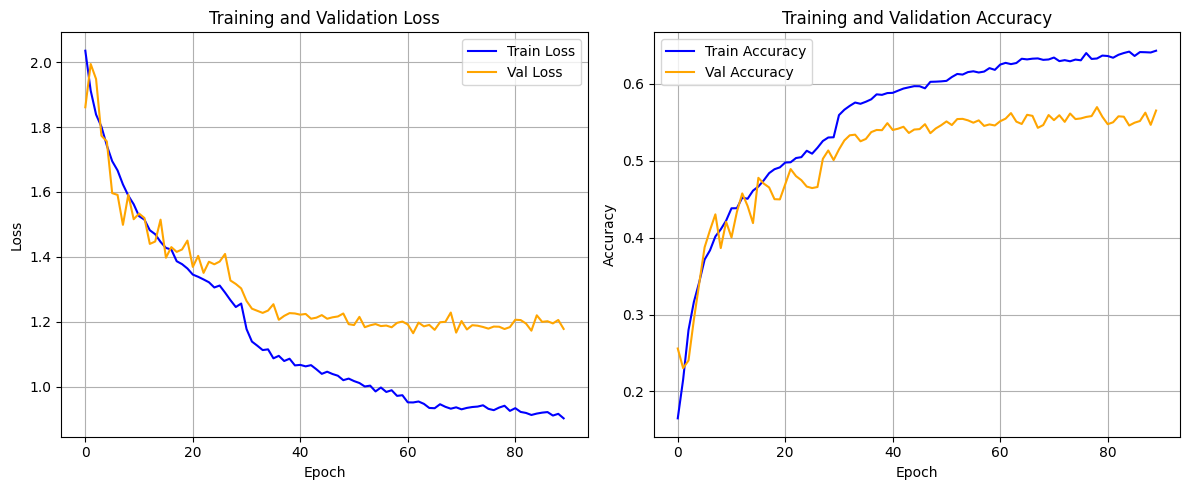

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_losses, color='blue', label='Train Loss')
ax[0].plot(val_losses, color='orange', label='Val Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(train_accs, color='blue', label='Train Accuracy')
ax[1].plot(val_accs, color='orange', label='Val Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [173]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5593550180706144
Test accuracy:  0.5684931506849316
